In [552]:
using DifferentialEquations, PyPlot, Statistics, LaTeXStrings, PyCall, LinearAlgebra, FFTW, Colors

In [556]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
lapaz = cmap.Colormap("crameri:lapaz").to_mpl();
rocket = cmap.Colormap("seaborn:rocket").to_mpl();
heat = cmap.Colormap("yorick:heat").to_mpl();
curl_pink = cmap.Colormap("cmocean:curl_pink").to_mpl();
arctic = cmap.Colormap("cmasher:arctic").to_mpl();

# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=30)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=30)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=24)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=24)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=24)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [3]:
""" 

######
        build Gell-Mann λ-matrices for the su(3) algebra (NOTE 1/2 factor)
#######

"""

λ1 = 1/2 * [0 1 0;
        1 0 0;
        0 0 0]

λ2 = 1/2*[0 -im  0;
        im  0  0;
        0   0  0]

λ3 = 1/2*[1  0 0;
        0 -1 0;
        0  0 0]

λ4 = 1/2*[0 0 1;
        0 0 0;
        1 0 0]

λ5 = 1/2*[0  0 -im;
        0  0   0;
        im 0   0]

λ6 = 1/2*[0 0 0;
        0 0 1;
        0 1 0]

λ7 = 1/2*[0  0   0;
        0  0  -im;
        0  im  0]
        
λ8 = (1/(2*sqrt(3)))*[1   0   0;
                0   1   0;
                0   0  -2]

                

λ_matrices = [λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8]

sum(λ_matrices[i]^2 for i in 1:8)


"""
    su3_d_tensor(lambdas::Vector{<:AbstractMatrix})

Compute the fully symmetric d_{i,j,k} tensor for SU(3) by
d[i,j,k] = 1/4 * tr( (lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]) * lambdas[k] ).
Returns an Array{Float64,3} of size (8,8,8).
"""
function su3_d_tensor(lambdas::Vector{Matrix{ComplexF64}})
    d = zeros(Float64, 8, 8, 8)
    for i in 1:8, j in 1:8, k in 1:8
        # compute the anticommutator {λ_i, λ_j}
        A = lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]

        d[i, j, k] = tr(A * lambdas[k]) / 4
    end
    return d
end

#Sum with cubic casimir of lambda matrices
dsu3 = su3_d_tensor(λ_matrices);

C3m = zeros(ComplexF64, 3, 3)

# sum over i,j,k
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k])
end
C3m

3×3 Matrix{ComplexF64}:
 0.138889+0.0im       0.0+0.0im       0.0+0.0im
      0.0+0.0im  0.138889+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  0.138889+0.0im

In [4]:
N1m = I(3)/3 + λ3 + 1/sqrt(3)*λ8
N0m = I(3)/3 - λ3 + 1/sqrt(3)*λ8
N2m = I(3)/3 - 2/sqrt(3)*λ8;

In [285]:
A = 1/2
γ = 0
β = 0
B = 1/2
C = sqrt(1-A^2-B^2)

a1 = A*B*cos(β)
a2 = A*B*sin(β)
a3 = 1/2*(A^2-B^2)
a4 = A*C*cos(γ)
a5 = A*C*sin(γ)
a6 = B*C*cos(γ-β)
a7 = B*C*sin(γ-β)
a8 = (-2+3*A^2+3B^2)/(2*sqrt(3))

# a1 = 0
# a2 = 0
# a3 = 0
# a4 = 0
# a5 = 0
# a6 = 0
# a7 = 0
# a8 = 0

# Definition of density matrix
rho0 = [1/3+a3+a8/sqrt(3) a1-im*a2 a4-im*a5;
a1+im*a2 1/3-a3+a8/sqrt(3) a6-im*a7;
a4+im*a5 a6+im*a7 1/3-2/sqrt(3)*a8]

# Physicality checks on rho & entries
det(rho0)
avec = [a1,a2,a3,a4,a5,a6,a7,a8]
sum(avec.^2)

0.33333333333333337

In [286]:
rho0

3×3 Matrix{ComplexF64}:
     0.25+0.0im      0.25-0.0im  0.353553-0.0im
     0.25+0.0im      0.25+0.0im  0.353553-0.0im
 0.353553+0.0im  0.353553+0.0im       0.5+0.0im

In [287]:
C3m = zeros(ComplexF64, 3, 3)
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= (rho0 * dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k]))
end
tr(C3m)


# tr(rho0*λ8)

0.1388888888888889 + 0.0im

In [288]:
sum(λ_matrices[i]^2 for i in 1:8)

# C3m

3×3 Matrix{ComplexF64}:
 1.33333+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.33333+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.33333+0.0im

In [289]:
# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, α_re, α_im = u

    # reconstruct complex field
    α    = α_re + im*α_im
    αc   = conj(α)
    expp = cis(φ)               # e^{iφ}
    expm = conj(expp)           # e^{-iφ}

    # λ-derivatives 
    dλ1 = -Δ1*λ2 + im*g*(λ3*(α-αc) + expm*αc/2*(-im*λ5+λ4) + expp*α/2*(-im*λ5-λ4))
    dλ2 =  Δ1*λ1 + im*g*(im*λ3*(α+αc) + expm*αc/2*(im*λ4+λ5) + expp*α/2*(im*λ4-λ5))
    dλ3 =  im*g*(-im*λ2*(α+αc) + λ1*(αc-α) + expm*αc/2*(im*λ7-λ6) + expp*α/2*(im*λ7+λ6))
    dλ4 = (-Δ1-Δ2)*λ5 + im*g*(αc/2*(im*λ7+λ6) + α/2*(im*λ7-λ6) + expm*αc/2*(-im*λ2-λ1) + expp*α/2*(-im*λ2+λ1))
    dλ5 = -(-Δ1-Δ2)*λ4 + im*g*(αc/2*(-im*λ6+λ7) + α/2*(-im*λ6-λ7) + expm*αc/2*(im*λ1-λ2) + expp*α/2*(im*λ1+λ2))
    dλ6 = -(Δ2)*λ7 + im*g* ( αc/2*(im*λ5-λ4) + α/2*(im*λ5+λ4) + 1/2*(expp*α - expm*αc)*(sqrt(3)*λ8 - λ3) )                 
    dλ7 =  (Δ2)*λ6 + im*g* ( αc/2*(-im*λ4-λ5) + α/2*(-im*λ4+λ5) + 1/2*(expp*α + expm*αc)*(im*sqrt(3)*λ8 - im*λ3) )
    dλ8 = -im*sqrt(3)/2*g*(αc*expm*(im*λ7-λ6) + α*expp*(im*λ7+λ6))

    du[1] = dλ1
    du[2] = dλ2
    du[3] = dλ3
    du[4] = dλ4
    du[5] = dλ5
    du[6] = dλ6
    du[7] = dλ7
    du[8] = dλ8

    # α-equation (split into real and imaginary parts)
    dα = (Δ*im - κ/2)*α - im*g*((λ1 - im*λ2) + expm*(λ6 - im*λ7)) + η
    du[9]  = real(dα)
    du[10] = imag(dα)
end  

coupled_eqs! (generic function with 1 method)

$\mathfrak{su}(3)$ quadratic and cubic Casimir operators $C_2$, $C_3$, define and check they remain constant over time

In [1031]:
# Fixed parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 0,0 #2π * 0.25*g , 2π * (0.25)*g  #, -2π *0.25*g
Δ = 0
ϕ = pi/2
η = 0.5*g 
# Time steps
tend = 500.0/g;
t_list = range(0.0, tend, length=10001);

# Initial conditions
u0 = zeros(10);  
for i in 1:8
    u0[i] = tr(rho0*λ_matrices[i])
end

In [1032]:
# Initial normalization checks: population, quadratic and cubic casimirs.
λt = sum([u0[i]^2 for i in 1:8])

C3 = 0
for i in 1:8, j in 1:8, k in 1:8
    C3 += sum(dsu3[i,j,k] * u0[i] * u0[j] * u0[k])
end



println("C₂ initial: ", λt)
println("C₃ initial: ", C3)
println("N₀ initial: ", (1/3 - u0[3] + 1/sqrt(3)*u0[8]))
println("N₁ initial: ", (1/3 + u0[3] + 1/sqrt(3)*u0[8]))
println("N₂ initial: ", (1/3 - 2/sqrt(3)*u0[8]))

C₂ initial: 0.3333333333333334
C₃ initial: 0.013888888888888897
N₀ initial: 0.24999999999999994
N₁ initial: 0.24999999999999994
N₂ initial: 0.5


In [1033]:
params = (Δ1, Δ2, g, ϕ, Δ, κ, η);
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params);
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-9, abstol=1e-9; maxiters=1e9);  # If stiff solver needed → pass "TRBDF2(autodiff=false)" to solve()

In [1034]:

# extract your lambdas and times
λ = sol[1:8, :]         # 8×Nt array of λ₁..λ₈
t = sol.t               # time vector
Nt = length(t)

# Compute Ni and quadratic Casimir if needed
N0 = (1/3 .- sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N1 = (1/3 .+ sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N2 =  (1/3 .- 2/sqrt(3).*sol[8,:])
Nt = N0 .+ N1 .+ N2
C2 = sum(λ .^ 2, dims=1)[:]   # quadratic Casimir


# cubic Casimir C3(t)
Ntsteps = length(sol.t)
dsu3 = su3_d_tensor(λ_matrices);
C3 = zeros(Float64, Ntsteps)
@inbounds for ti in 1:Ntsteps
    for i in 1:8, j in 1:8, k in 1:8
        C3[ti] += dsu3[i,j,k] * λ[i,ti] * λ[j,ti] * λ[k,ti]
    end
end

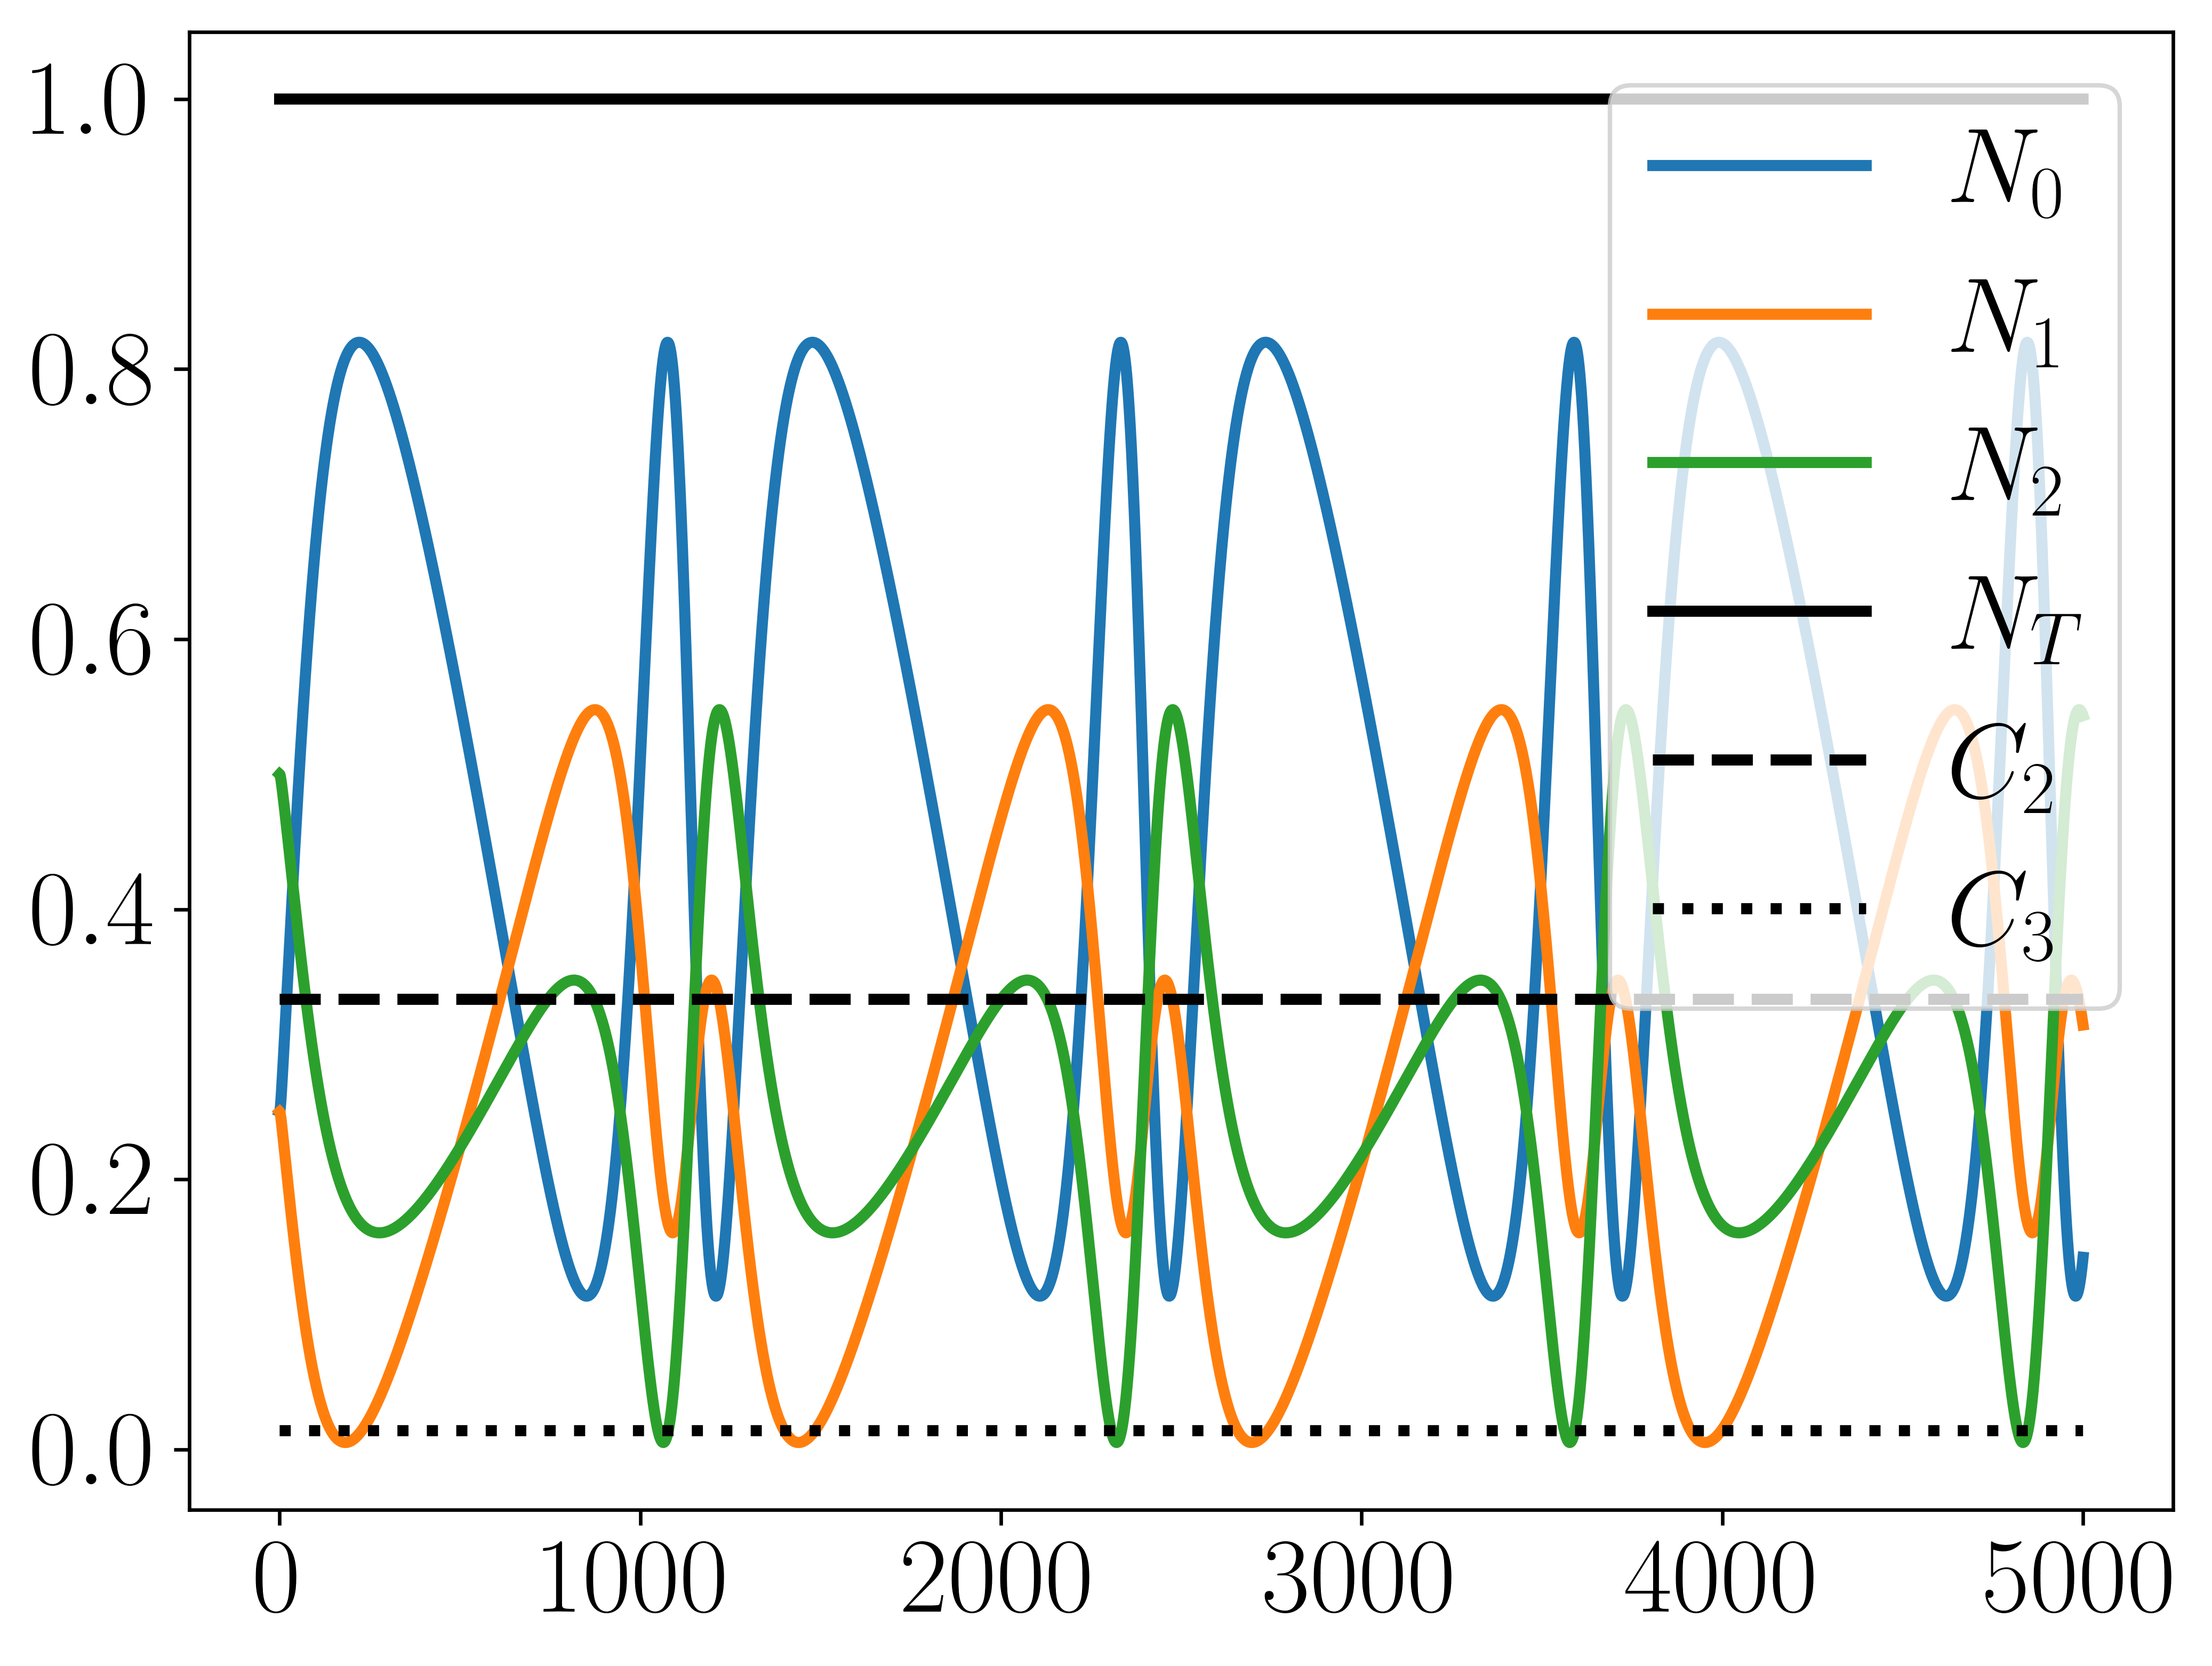

In [1035]:
fig, ax= subplots(figsize=(8, 6), dpi=600)
ax.plot(t, N0, lw=2.5, label=L"N_0")
ax.plot(t, N1, lw=2.5, label=L"N_1")
ax.plot(t, N2, lw=2.5, label=L"N_2")
ax.plot(t, Nt, lw=2.5, linestyle="-", color="black", label=L"N_T")
ax.plot(t, C2, lw=2.5, linestyle="--", color="black", label=L"$C_2$")
ax.plot(t, C3, lw=2.5, linestyle=":", color="black", label=L"$C_3$")
# ax.plot(t, sol[1,:] + sol[6,:], label=L"1,6", lw=4)
# ax.plot(t, sol[3,:] + sqr't(3)*sol[8,:], label=L"3,8", lw4)
# ax.plot(t, sol[2,:] + sol[7,:], label=L"2,7", lw=4)
# ax.plot(t, (sol[1,:] .+ sol[6,:]).^2 + (sol[3,:] .+ sqrt(3)*sol[8,:]).^2 .+ (sol[2,:] .+ sol[7,:]).^2, label="tot", lw=4)
# ax.set_xscale("log")
ax.legend(loc="upper right")
display(fig)

In [395]:
#Sample data 


n = length(N1)

Fs = 1/(t[2] - t[1])  # Replace with your sampling frequency (Hz)

# Preprocess data
N0_detrend = N1 .- mean(N1)
window = 0.5 .* (1 .- cos.(2π .* (0:n-1) ./ (n-1)))
N0_windowed = N0_detrend .* window

# Compute FFT

fft_N0 = fft(N1)
mag = abs.(fft_N0)

# One-sided spectrum adjustment
if n % 2 == 0
    mag_one_sided = mag[1:(n÷2 + 1)]
    mag_one_sided[2:end-1] .*= 2
else
    mag_one_sided = mag[1:((n+1) ÷ 2)]
    mag_one_sided[2:end] .*= 2
end

# Frequency axis
freq = Fs .* (0:(length(mag_one_sided)-1)) ./ n


0.0:9.999000099990002e-5:0.4999500049995001

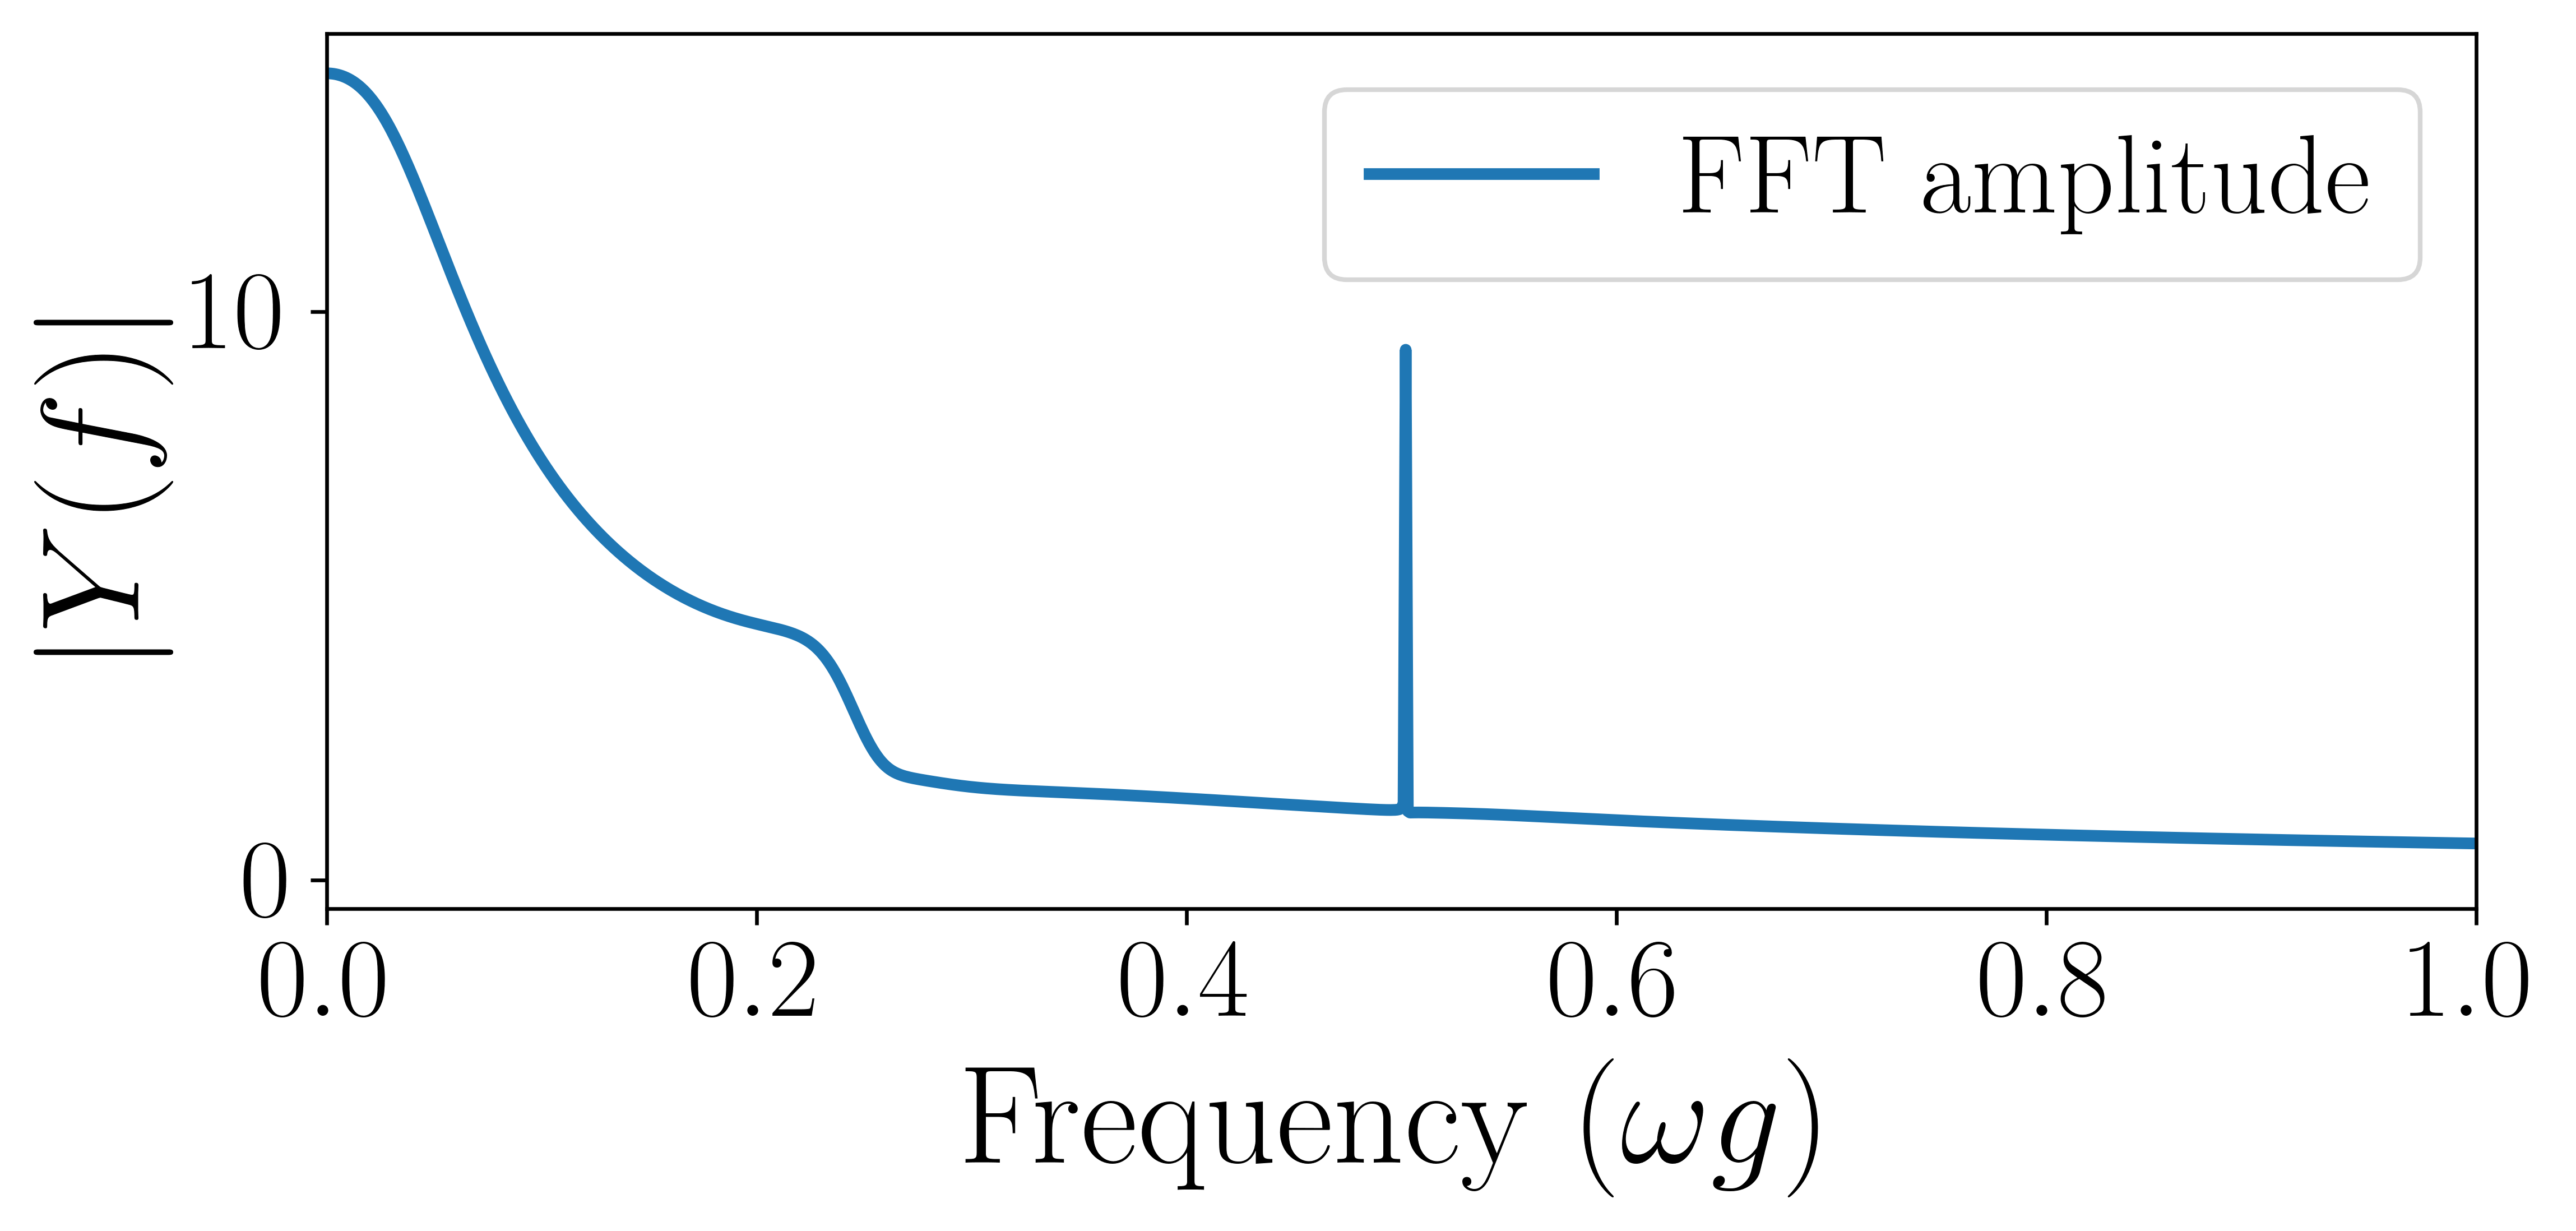

In [396]:
fig, ax = subplots(figsize=(8, 4), dpi=600)
plot(freq[2:end]./g, mag_one_sided[2:end],  label="FFT amplitude", lw=2.5)
xlim(0,1)
xlabel(L"Frequency $(\omega g)$")
ylabel(L"|Y(f)|")
legend()
tight_layout()
display(fig)

In [314]:
minimum(hcat(N0, N1, N2))

0.00017955479343123582

Map out mean field phase diagram 

In [ ]:
# Parameter setup
η_vals = range(0.1*g, 1.0*g, length=301)
φ_vals = range(-π, π, length=301)
# Δ_vals = range(-1.0*g, 1.0*g, length=41)

# Preallocate variance and mean arrays
var_N0 = zeros(length(φ_vals), length(η_vals))
var_N1 = zeros(length(φ_vals), length(η_vals))
var_N2 = zeros(length(φ_vals), length(η_vals))
var_adaga = zeros(length(φ_vals), length(η_vals))
var_argcav = zeros(length(φ_vals), length(η_vals))


mean_N0 = zeros(length(φ_vals), length(η_vals))
mean_N1 = zeros(length(φ_vals), length(η_vals))
mean_N2 = zeros(length(φ_vals), length(η_vals))
mean_adaga = zeros(length(φ_vals), length(η_vals))
mean_argcav = zeros(length(φ_vals), length(η_vals))


# coherence arrays
mean_rho01 = zeros(length(φ_vals), length(η_vals))
var_rho01  = zeros(length(φ_vals), length(η_vals))
mean_rho02 = zeros(length(φ_vals), length(η_vals))
var_rho02  = zeros(length(φ_vals), length(η_vals))
mean_rho12 = zeros(length(φ_vals), length(η_vals))
var_rho12  = zeros(length(φ_vals), length(η_vals))
# --------------------------------------------------

#Circular statistics
circ_var_argcav = zeros(length(φ_vals), length(η_vals))
circ_mean_argcav = zeros(length(φ_vals), length(η_vals))


# Steady-state window: last 40% of the time series
total_pts = length(t_list)
ss_start = round(Int, 0.6 * total_pts):total_pts

# Loop over φ and η
for (i, φ_val) in enumerate(φ_vals)
    for (j, η_val) in enumerate(η_vals)
        # Update parameters and initial condition
        params = (0, 0, g, φ_val, Δ, κ, η_val)
        prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)

        # Solve
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-6)



        # Extract steady-state data
        N0_ss =  1/3 .- sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N1_ss = 1/3 .+ sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N2_ss = 1/3 .- 2/sqrt(3) .* sol[8,:];
        ax_ss = sol[end-1,ss_start]
        ap_ss = sol[end,ss_start]
        argcav_ss = angle.(ax_ss + 1im*ap_ss)  # Argument of the cavity field
        adaga_ss = ax_ss.^2 + ap_ss.^2  # Adaga = |a|^2
        
        λ1_ss = sol[1, ss_start]
        λ2_ss = sol[2, ss_start]
        λ4_ss = sol[4, ss_start]
        λ5_ss = sol[5, ss_start]
        λ6_ss = sol[6, ss_start]
        λ7_ss = sol[7, ss_start]

        # --- build coherences in SS window
        rho01_ss = @. (λ1_ss + im*λ2_ss) / 2
        rho02_ss = @. (λ6_ss + im*λ7_ss) / 2
        rho12_ss = @. (λ4_ss + im*λ5_ss) / 2
    
        # --- record mean and variance of the absolute value
        mean_rho01[i,j] = mean(abs.(rho01_ss))
        var_rho01[i,j]  = var(abs.(rho01_ss))
    
        mean_rho02[i,j] = mean(abs.(rho02_ss))
        var_rho02[i,j]  = var(abs.(rho02_ss))
    
        mean_rho12[i,j] = mean(abs.(rho12_ss))
        var_rho12[i,j]  = var(abs.(rho12_ss))
        # Compute variances and mean
        var_N0[i, j] = var(N0_ss)
        var_N1[i, j] = var(N1_ss)
        var_N2[i, j] = var(N2_ss)
        var_adaga[i, j] = var(adaga_ss)
        var_argcav[i, j] = var(argcav_ss)

        # Compute means
        mean_N0[i,j] = mean(N0_ss)
        mean_N1[i,j] = mean(N1_ss)
        mean_N2[i,j] = mean(N2_ss)
        mean_adaga[i,j] = mean(adaga_ss)
        mean_argcav[i,j] = mean(argcav_ss)


    end
end

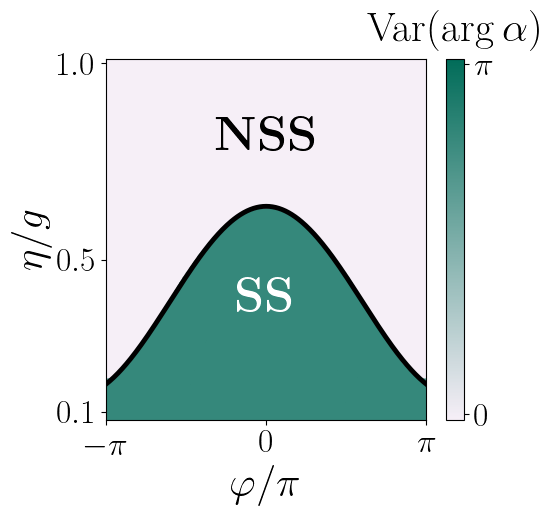

In [819]:
### Phase diagram of the cavity field (phase or amplitude variance)

@pyimport matplotlib.colors as mcolors

# Choose two clearly distinct pastel hex‐colors:
#   - pastel_blue  = "#aec6cf"
#   - pastel_peach = "#ffdab9"
#
# (These could be any two colors you like, e.g. ["#377eb8", "#e41a1c"] for a stronger contrast.)
#cmap = mcolors.ListedColormap(["#f6eff7", "#016c59"])
cmap = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#f6eff7", "#016c59"])
"""
Plot the variance phase diagram.

"""
x = φ_vals./π
y = η_vals./g
# x = Δ_vals./g
clims =  (0,pi) #(1e-3, 1e-0) 
cmap = cmap#"binary"

xtick_locs = [-1.0, 0,  1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"0", L"\pi"]
ytick_locs = [0.12, 0.5, 0.99]  # y = η/g
ytick_labels = [L"0.1", L"0.5", L"1.0"]

fig, axs = subplots(1, 1, figsize=(5.5, 5.5))


im1 = imshow((var_argcav .% π)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim = clims)     
axs.set_ylabel(L"\eta/g")
axs.set_xlabel(L"\varphi/\pi")

axs.set_xticks(xtick_locs)
axs.set_xticklabels(xtick_labels)
axs.set_yticks(ytick_locs)
axs.set_yticklabels(ytick_labels)


fncx = (0.238 .* (cos.(0.83.*x.* pi)) .+0.395) # Function for the line in the phase diagram
axs.plot(x, fncx, color="black", linewidth=3.5)

cbar = colorbar(im1, ax=axs)

#Cbar ticks
cbar.set_ticks([0.05, 3.1])
cbar.set_ticklabels([L"0", L"\pi"])

#Set colorbar label as the variance of N1 and N2, horizontally aligned on top of the colorbar
cbar.ax.set_title(L"\mathrm{Var}(\arg{\alpha})", pad=13)

#Add text description to the two states inside phase diagram
axs.text(0.0, 0.4, L"\textbf{SS}", fontsize=35, ha="center", va="center", color="white")
axs.text(0.0, 0.8, L"\textbf{NSS}", fontsize=35, ha="center", va="center",color="black")
tight_layout()
display(fig)
#savefig("../figs/spin1/var_argcav.pdf", bbox_inches="tight", dpi=800)

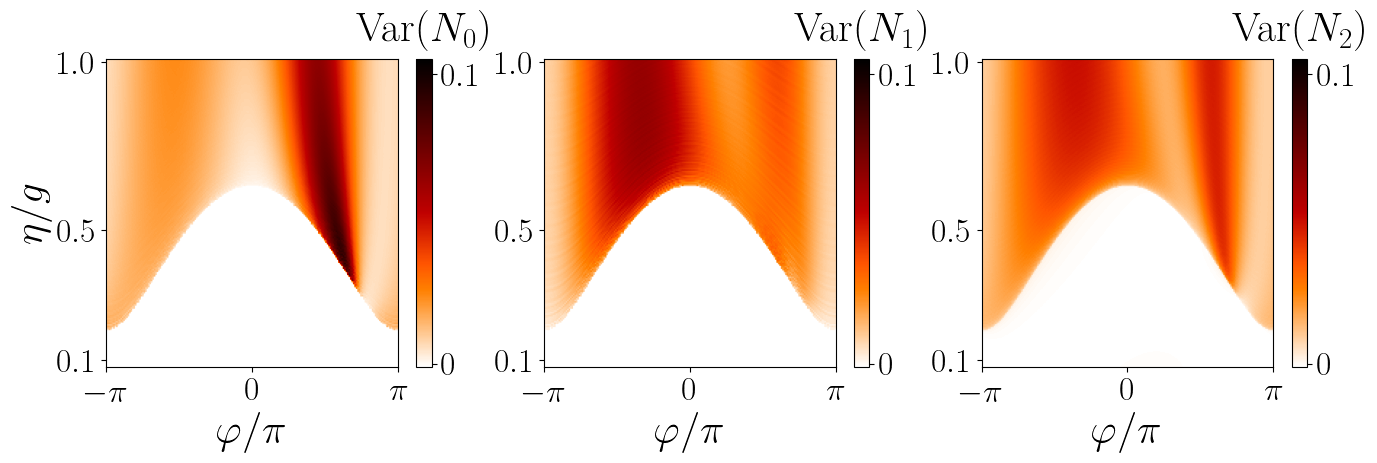

In [397]:
"""
Plot the variance phase diagram for a given N_i.

"""
x = φ_vals./π
y = η_vals./g
# x = Δ_vals./g
clims =  (0,0.1) #(1e-3, 1e-0) 
cmap = heat.reversed()

xtick_locs = [-1.0, 0,  1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"0", L"\pi"]
ytick_locs = [0.12, 0.5, 0.99]  # y = η/g
ytick_labels = [L"0.1", L"0.5", L"1.0"]

fig, axs = subplots(1, 3, figsize=(16, 4))


im1 = axs[1].imshow((var_N0)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim = clims)     
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
#axs[1].set_xlabel(L"\Delta_s/g")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
axs[1].set_yticks(ytick_locs)
axs[1].set_yticklabels(ytick_labels)

im2 = axs[2].imshow((var_N1)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[2].set_ylabel(L"\eta/g")
 axs[2].set_xlabel(L"\varphi/\pi")
#axs[2].set_xlabel(L"\Delta_s/g")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)
axs[2].set_yticks(ytick_locs)
axs[2].set_yticklabels(ytick_labels)

im3 = axs[3].imshow((var_N2)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[3].set_ylabel(L"\eta/g")
axs[3].set_xlabel(L"\varphi/\pi")
#axs[3].set_xlabel(L"\Delta_s/g")
axs[3].set_xticks(xtick_locs)
axs[3].set_xticklabels(xtick_labels)
axs[3].set_yticks(ytick_locs)
axs[3].set_yticklabels(ytick_labels)

cbar1 = colorbar(im1, ax=axs[1])
cbar2 = colorbar(im2, ax=axs[2])
cbar3 = colorbar(im3, ax=axs[3])
#Cbar ticks
cbar1.set_ticks([0.001, 0.095])
cbar1.set_ticklabels([L"0", L"0.1"])
cbar2.set_ticks([0.001, 0.095])
cbar2.set_ticklabels([L"0", L"0.1"])
cbar3.set_ticks([0.001, 0.095])
cbar3.set_ticklabels([L"0", L"0.1"])
#Set colorbar label as the variance of N1 and N2, horizontally aligned on top of the colorbar
cbar1.ax.set_title(L"\mathrm{Var}(N_0)", pad=13)
cbar2.ax.set_title(L"\mathrm{Var}(N_1)", pad=13)
cbar3.ax.set_title(L"\mathrm{Var}(N_2)", pad=13)

# cbar1.ax.set_title(L"\langle N_0\rangle", pad=13)
# cbar2.ax.set_title(L"\langle N_1\rangle", pad=13)
# cbar3.ax.set_title(L"\langle N_2\rangle", pad=13)
display(fig)
# savefig("../figs/spin1/var_N0_N1_N2.svg", bbox_inches="tight", dpi=600)

NOTE: 

PARAMETERS FOR WHICH NON-RECIPROCITY ARISES:

A = 0.5
γ = 0
β = 0
B = 0.5

$\Delta_{1,2}=0$


PRIORITIZE WORKING WITH THIS INITIAL DENSITY MATRIX!!!

PARAMETERS FOR (e)DFS:

A = $1/\sqrt(2)$
γ = 0
β = 0
B = $1/\sqrt(2)$

$\Delta_{1,2}=0$


PRIORITIZE WORKING WITH THIS INITIAL DENSITY MATRIX!!!



In [ ]:
# Create composite matrix for heatmap (N1 | N0 | N2)
heatmap_data = [N1 N0 N2]

# Plot
fig, ax = subplots(figsize=(4.25, 5.5))
im1 = ax.imshow(heatmap_data, 
              aspect="auto",
              cmap=lajolla.reversed(), clim=(0, 1),
              interpolation="none",
              extent=[0.5, 3.5, t[1]*g, t[end]*g])

# Formatting
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([L"\langle N_1\rangle", L"\langle N_0\rangle", L"\langle N_2\rangle"])
ax.set_ylabel(L"Time $\,gt$")
ax.set_yticks([0, 499, 999])
ax.set_yticklabels([0, 500, 1000])
cbar = fig.colorbar(im1, label=L"P(N_i)")
cbar.set_ticks([0.01, 0.99])
cbar.set_ticklabels([L"0", L"1"])
tight_layout()

#display(fig)
savefig("../figs/spin1/N0_N1_N2.pdf", dpi=800, bbox_inches="tight")

In [849]:
sort(mean_adaga, rev=true, dims=1)

301×301 Matrix{Float64}:
 3.30464e-13  3.30518e-13  3.30559e-13  …  0.0384349  0.0388375  0.0391525
 3.30447e-13  3.30495e-13  3.30544e-13     0.0384337  0.0388369  0.039152
 3.30439e-13  3.30485e-13  3.30544e-13     0.0384329  0.0388357  0.039152
 3.30432e-13  3.30474e-13  3.3052e-13      0.0384291  0.0388338  0.0391514
 3.30431e-13  3.30472e-13  3.30515e-13     0.0384275  0.0388338  0.0391503
 3.3042e-13   3.30469e-13  3.30501e-13  …  0.0384275  0.0388316  0.0391485
 3.30391e-13  3.30463e-13  3.30498e-13     0.0384212  0.038828   0.0391475
 3.30374e-13  3.30447e-13  3.30498e-13     0.0384188  0.0388251  0.0391438
 3.30372e-13  3.30435e-13  3.30483e-13     0.0384098  0.0388191  0.0391434
 3.30349e-13  3.30418e-13  3.30481e-13     0.0384068  0.0388163  0.0391393
 ⋮                                      ⋱                        ⋮
 3.1508e-13   3.15288e-13  3.15392e-13     0.0257099  0.0259217  0.0260948
 3.1488e-13   3.15105e-13  3.15214e-13     0.0257071  0.0259039  0.0260701
 3.14826e-

In [ ]:
x = φ_vals ./ π
y = η_vals ./ g
clims1 = (0,1)
xtick_locs  = [-1.0, 0, 1.0]
xtick_labels = [L"-\pi", L"0", L"\pi"]
ytick_locs  = [0.12, 0.5, 0.99]
ytick_labels = [L"0.1", L"0.5", L"1.0"]

# For the heatmap (“N0_N1_N2”):
#   (assuming N1, N0, N2, lajolla, t, g are already defined)
heatmap_data = [N1 N0 N2]
clims2 = (0, 1)

# ─── Create a single Figure with a 1×2 GridSpec ──────────────────────────────

# Total figsize = (5.5 + 4, 5.5) = (9.5, 5.5)
fig = figure(figsize = (9.5, 5.5))

# Make a GridSpec with two columns and custom width ratios [5.5, 4]
@pyimport matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2; width_ratios = [5.5, 4])

# Now grab each subplot from the GridSpec:
ax1 = subplot(gs[0, 1])   # left panel (phase diagram)
ax2 = subplot(gs[0, 0])   # right panel (heatmap)

# ─── Left panel: phase diagram (exactly your old figcav code) ────────────────

im1 = ax1.imshow(
    (fpeak_N2)' * 1/maximum(fpeak_N2), 
    extent = (minimum(x), maximum(x), minimum(y), maximum(y)),
    origin = "lower",
    aspect = "auto",
    cmap = cmap,
    clim = clims1
)
ax1.set_xlabel(L"\varphi")
ax1.set_ylabel(L"\eta/g")
ax1.set_xticks(xtick_locs)
ax1.set_xticklabels(xtick_labels)
ax1.set_yticks(ytick_locs)
ax1.set_yticklabels(ytick_labels)

# boundary line in the phase diagram
fncx = (0.238 .* cos.(0.83 .* x .* π) .+ 0.395)
ax1.plot(x, fncx, color = "black", linewidth = 4)

# colorbar for the left panel
cbar1 = colorbar(im1, ax = ax1)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels([L"0", L"1"])

cbar1.ax.set_title(L"\tilde{\omega}", pad=13)
# “SS” / “NSS” labels
ax1.text(0.0, 0.4, L"\textbf{SS}",
         fontsize = 35, ha = "center", va = "center", color = "black")
ax1.text(0.0, 0.8, L"\textbf{NSS}",
         fontsize = 35, ha = "center", va = "center", color = "white")

# “a)” label in the upper‐left (axes-fraction coords)
ax1.text(-0.3, 1.15, "a)",
         transform = ax1.transAxes,
         fontsize = 30, va = "top", ha = "left")
ax1.text(
    0.05, 1, L"\Delta_1=\Delta_2=0",
    transform = ax1.transAxes,
    fontsize = 24,
    va = "top",
    ha = "left",
    bbox = Dict(
        "facecolor"  => "white",
        "edgecolor"  => "black",
        "boxstyle"   => "round,pad=0.2"
    )
)

ax1.plot(
    0.55, 0.5,
    marker = "o",
    markersize = 12,
    markerfacecolor = lajolla.reversed()(0.65),
    markeredgecolor = lajolla.reversed()(0.25),
    markeredgewidth = 2,   # thicker edge
    linestyle = "", 
)

# ─── Right panel: heatmap (exactly your old figpop code) ───────────────────────

im2 = ax2.imshow(
    heatmap_data,
    aspect = "auto",
    cmap = lajolla.reversed(),
    clim = clims2,
    interpolation = "none",
    extent = [0.5, 3.5, t[1] * g, t[end] * g]
)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels([L"\langle N_1\rangle", L"\langle N_0\rangle", L"\langle N_2\rangle"])
ax2.set_ylabel(L"Time\,\,$gt$")
ax2.set_yticks([0, 249, 499])
ax2.set_yticklabels([0, 250, 500])

cbar2 = colorbar(im2, ax = ax2)
cbar2.ax.set_title(L"P(N_i)", pad = 13)
cbar2.set_ticks([0.01, 0.99])
cbar2.set_ticklabels([L"0", L"1"])

# “b)” label in the upper‐left of the right subplot
ax2.text(-0.3, 1.15, "b)",
         transform = ax2.transAxes,
         fontsize = 30, va = "top", ha = "left")

# ─── Final tweaks ───────────────────────────────────────────────────────────────

tight_layout()
display(fig)
# savefig("../figs_for_paper/fig3.svg", dpi=800, bbox_inches="tight")

In [1001]:
# Parameter setup
η_vals = range(0.1*g, 1.0*g, length=101)
φ_vals = range(-π, π, length=101)
N  = length(t_list)

# “Steady‐state” window: second half of t_list
steady_idx = collect(div(length(t_list), 2):length(t_list))

# Preallocate arrays for the peak‐frequency indices of N0, N1, N2:
fpeak_N0 = zeros(Float64, length(φ_vals), length(η_vals))
fpeak_N1 = zeros(Float64, length(φ_vals), length(η_vals))
fpeak_N2 = zeros(Float64, length(φ_vals), length(η_vals))

# Main double loop
for (iφ, φ_val) in enumerate(φ_vals)
    for (iη, η_val) in enumerate(η_vals)
        # (1) Build & solve the ODEProblem
        params = (0, 0, g, φ_val, Δ, κ, η_val)
        prob   = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
        sol    = solve(prob, Tsit5(); saveat = t_list,
                                 reltol = 1e-6, abstol = 1e-6)

        # (2) Extract “steady‐state” slices of N0, N1, N2
        N0_ss = @. 1/3 - sol[3, :] + (1/sqrt(3)) * sol[8, :]
        N1_ss = @. 1/3 + sol[3, :] + (1/sqrt(3)) * sol[8, :]
        N2_ss = @. 1/3 - (2/sqrt(3)) * sol[8, :]


        # Full FFTs
        fft_N0 = fft(N0_ss)
        fft_N1 = fft(N1_ss)
        fft_N2 = fft(N2_ss)

        fft_N0 = fft_N0[2:div(N, 2) + 1]
        fft_N1 = fft_N1[2:div(N, 2) + 1]
        fft_N2 = fft_N2[2:div(N, 2) + 1]

        P1_N0 = abs.(fft_N0[1:end]) ./ N
        P1_N1 = abs.(fft_N1[1:end]) ./ N
        P1_N2 = abs.(fft_N2[1:end]) ./ N

        fpeak_N0[iφ, iη] = P1_N0[argmax(P1_N0)]
        fpeak_N1[iφ, iη] = P1_N1[argmax(P1_N1)]
        fpeak_N2[iφ, iη] = P1_N2[argmax(P1_N2)]

    end
end

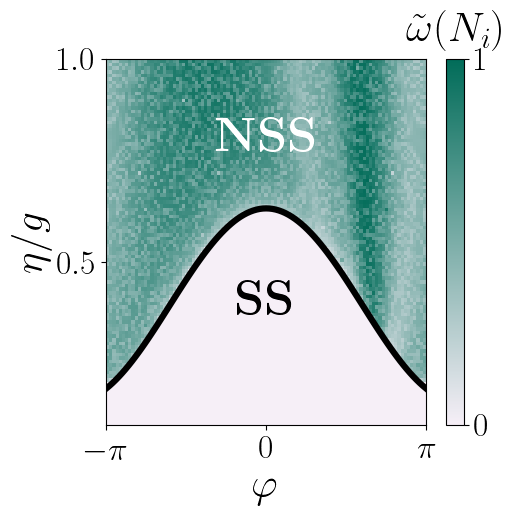

In [1011]:
### Phase diagram of the cavity field (phase or amplitude variance)

x = φ_vals./π
y = η_vals./g

cmap = cmap

xtick_locs = [-1.0, 0,  1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"0", L"\pi"]
ytick_locs = [0.5, 1.0]  # y = η/g
ytick_labels = [L"0.5", L"1.0"]

fig, axs = subplots(1, 1, figsize=(5.5, 5.5))


im1 = imshow((fpeak_N2)' * 1/maximum(fpeak_N2) ,
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim = (0,1))     
axs.set_ylabel(L"\eta/g")
axs.set_xlabel(L"\varphi")

axs.set_xticks(xtick_locs)
axs.set_xticklabels(xtick_labels)
axs.set_yticks(ytick_locs)
axs.set_yticklabels(ytick_labels)


fncx = (0.238 .* (cos.(0.83.*x.* pi)) .+0.395) # Function for the line in the phase diagram
axs.plot(x, fncx, color="black", linewidth=4.5)

cbar = colorbar(im1, ax=axs)

#Cbar ticks
cbar.set_ticks([0, 1])
cbar.set_ticklabels([L"0", L"1"])

#Set colorbar label as the variance of N1 and N2, horizontally aligned on top of the colorbar
cbar.ax.set_title(L"\tilde{\omega}(N_i)", pad=13)

#Add text description to the two states inside phase diagram
axs.text(0.0, 0.4, L"\textbf{SS}", fontsize=35, ha="center", va="center", color="black")
axs.text(0.0, 0.8, L"\textbf{NSS}", fontsize=35, ha="center", va="center",color="white")
tight_layout()
display(fig)
#savefig("../figs/spin1/var_argcav.pdf", bbox_inches="tight", dpi=800)

In [984]:
# Fixed parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 0,0 
Δ = 0
ϕ = 2pi/3
η = 0.4*g 
# Time steps
tend = 100000.0/g;
t_list = range(0.0, tend, length=1001);

# Initial conditions
u0 = zeros(10);  
for i in 1:8
    u0[i] = tr(rho0*λ_matrices[i])
end

params = (Δ1, Δ2, g, ϕ, Δ, κ, η);
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params);
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-6);  # If stiff solver needed → pass "TRBDF2(autodiff=false)" to solve()

λ = sol[1:8, :]         # 8×Nt array of λ₁..λ₈
t = sol.t               # time vector
Nt = length(t)

# Compute Ni and quadratic Casimir if needed
N0 = (1/3 .- sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N1 = (1/3 .+ sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N2 =  (1/3 .- 2/sqrt(3).*sol[8,:]);

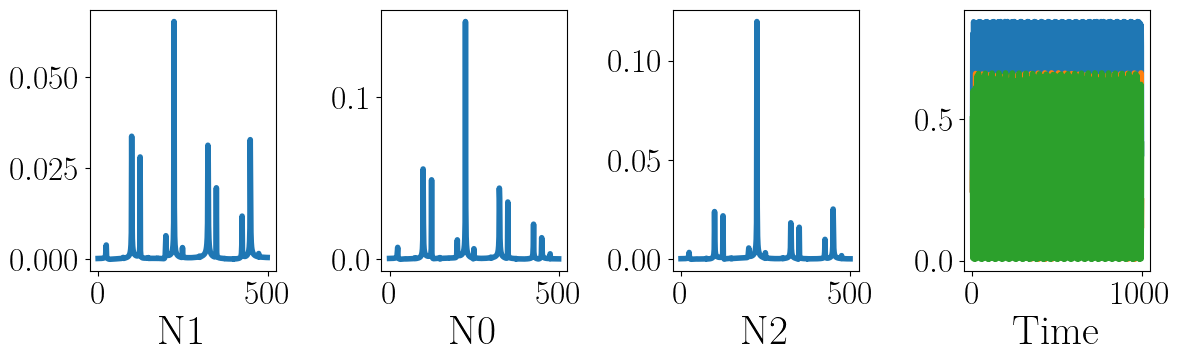

In [985]:
N  = length(t_list)
dt = t_list[2] - t_list[1]    # assuming uniform spacing


# Full FFTs
fft_N0 = fft(N0)
fft_N1 = fft(N1)
fft_N2 = fft(N2)

# Take only one side
fft_N0 = fft_N0[2:div(N, 2) + 1]
fft_N1 = fft_N1[2:div(N, 2) + 1]
fft_N2 = fft_N2[2:div(N, 2) + 1]

P1_N0 = abs.(fft_N0[1:end]) ./ N
P1_N1 = abs.(fft_N1[1:end]) ./ N
P1_N2 = abs.(fft_N2[1:end]) ./ N


fig, ax = subplots(1, 4, figsize = (12, 4))


ax[2].plot(P1_N0, lw = 4)
ax[2].set_xlabel("N0")



ax[1].plot(P1_N1, lw = 4)
ax[1].set_xlabel("N1")

ax[3].plot(P1_N2, lw = 4)
ax[3].set_xlabel("N2")



ax[4].plot(N0, lw = 4)
ax[4].plot(N1, lw = 4)
ax[4].plot(N2, lw = 4)
ax[4].set_xlabel("Time")

tight_layout()

display(fig)

In [987]:
argmax(P1_N0)
argmax(P1_N1)
argmax(P1_N2)

# Peak frequencies
fpeak_N0 = P1_N0[argmax(P1_N0)]
fpeak_N1 = P1_N1[argmax(P1_N1)]
fpeak_N2 = P1_N2[argmax(P1_N2)]

0.1196129711953605